# Import

In [ ]:
pip install bayesian_bootstrap

In [1]:
import numpy as np
# from bayesian_bootstrap import bayesian_bootstrap
from ClinicalUtilityProfiling import *


# Data Prep

In [2]:
#Dataset
from sklearn.datasets import make_classification

# Set random seed for reproducibility
np.random.seed(42)

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")


Feature shape: (1000, 2)
Target shape: (1000,)


In [3]:
#Specifications
#H/B

# Bayesian Bootstrapping

In [4]:
def bayesian_bootstrap(X, y, n_iterations=1000):
    n = len(y)
    bootstrapped_X = []
    bootstrapped_y = []
    
    for _ in range(n_iterations):
        # Sample weights from a Dirichlet distribution
        weights = np.random.dirichlet(np.ones(n))
        indices = np.random.choice(np.arange(n), size=n, replace=True, p=weights)
        bootstrapped_X.append(X[indices])
        bootstrapped_y.append(y[indices])
    
    return np.array(bootstrapped_X), np.array(bootstrapped_y)

# Apply Bayesian bootstrap to the dataset
bootstrapped_X, bootstrapped_y = bayesian_bootstrap(X, y, n_iterations=1000)

In [5]:
bootstrapped_X[0]

array([[-0.57003389, -0.2724515 ],
       [ 0.11993682, -1.07930252],
       [-0.01187157, -2.29793703],
       ...,
       [ 2.01860348,  1.94404453],
       [ 0.1416551 ,  0.30245273],
       [ 1.46437739, -1.67560674]])

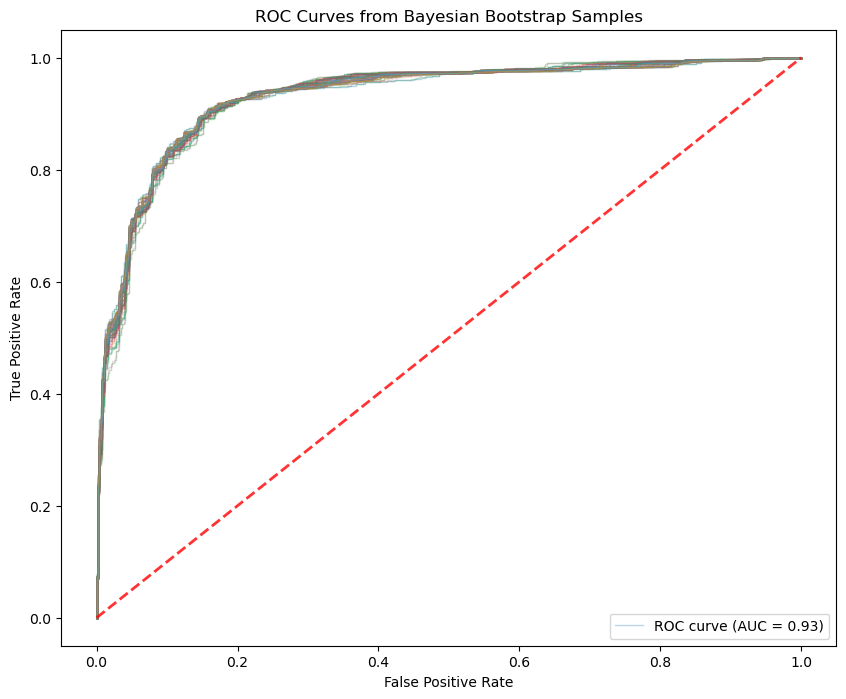

Mean AUC: 0.9324
Standard deviation of AUC: 0.0005


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Initialize a list to store AUC scores
auc_scores = []

for i in range(100):
    #For each bootstrap

    # Train logistic regression on the i-th bootstrapped sample
    model = LogisticRegression()
    model.fit(bootstrapped_X[i], bootstrapped_y[i])
    
    #get empirical roc
    # Compute the ROC curve and AUC score
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

plt.title('ROC Curves from Bayesian Bootstrap Samples')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Display summary statistics for AUC scores
print(f"Mean AUC: {np.mean(auc_scores):.4f}")
print(f"Standard deviation of AUC: {np.std(auc_scores):.4f}")


In [6]:
thresholds[np.isinf(thresholds)] = 1


In [10]:
pDisease = 0.5
dU = 0
# uTPs = np.arange(0, 1.05, 0.05)
uTPs = [0.005]
model_idx = 0
HoverBs = [1/100000, 1/10000, 1/1000]
HoverBs = np.append(HoverBs, np.arange(0.01, 2.5, 0.01))
# HoverBs = np.append(HoverBs, np.arange(2.5, 100, 0.1))
# HoverBs = np.append(HoverBs, np.arange(100, 1000, 10))
# HoverBs = np.append(HoverBs, np.arange(0, 1.0/uTPs[0], 0.01))
maxEUs, pLs, pUs, prob_cutoffs = cup(pDisease, fpr, tpr, thresholds, HoverBs, uTPs, dU)
# Interpolating Z values onto a grid
X, Y = np.meshgrid(uTPs, HoverBs)
# Z, Z1, Z2 = cup(pDisease, fprs, tprs, costRatios, uTPs, dU)
Z1 = maxEUs.reshape(len(uTPs), len(HoverBs))
Z2 = pLs.reshape(len(uTPs), len(HoverBs))
Z3 = pUs.reshape(len(uTPs), len(HoverBs))
Z4 = prob_cutoffs.reshape(len(uTPs), len(HoverBs))
priorRange = pUs - pLs
priorRange = np.array([x if x >= 0 else 0 for x in priorRange])
Z5 = priorRange.reshape(len(uTPs), len(HoverBs))


0.005
Took:  10.819630146026611  seconds.


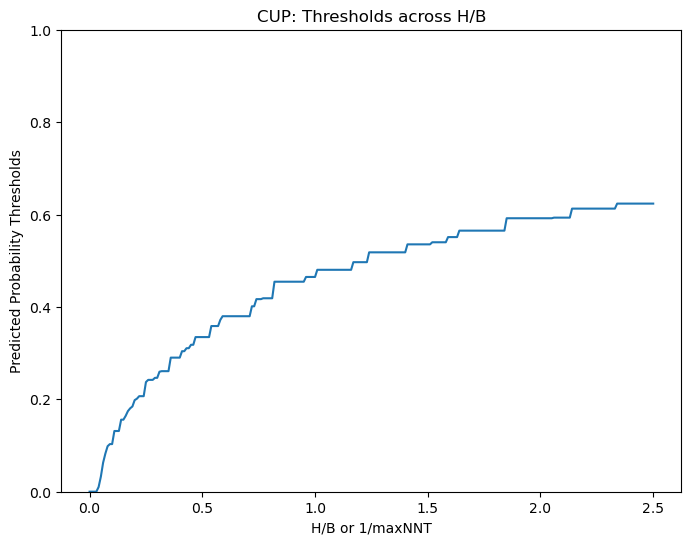

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(HoverBs, prob_cutoffs)  # 'marker=o' adds a circle marker at each data point

# Adding title and labels
plt.title('CUP: Thresholds across H/B')
plt.xlabel('H/B or 1/maxNNT')
plt.ylabel('Predicted Probability Thresholds')
# Show the plot
plt.ylim([0.0, 1.0])
plt.show()

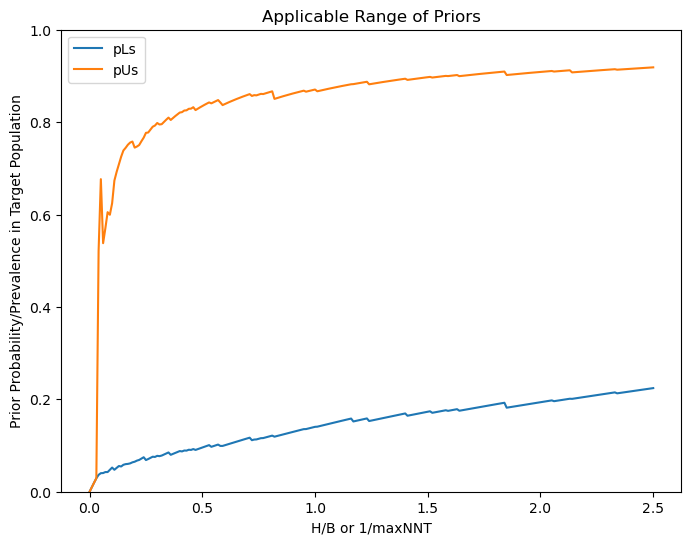

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(HoverBs, pLs, label='pLs')  # 'marker=o' adds a circle marker at each data point
plt.plot(HoverBs, pUs, label='pUs')  # 'marker=o' adds a circle marker at each data point
# Adding title and labels
plt.title('Applicable Range of Priors')
plt.xlabel('H/B or 1/maxNNT')
plt.ylabel('Prior Probability/Prevalence in Target Population')
plt.legend()
plt.ylim([0.0, 1.0])
# Show the plot
plt.show()

In [14]:
util = [0.005, dU]
outer_idx = max_relative_slopes(fpr, tpr)[1]
outer_idx = clean_max_relative_slope_index(outer_idx, len(tpr))
u_roc_fpr_fitted, u_roc_tpr_fitted = fpr[outer_idx], tpr[outer_idx]
u_roc_fpr_fitted, u_roc_tpr_fitted = deduplicate_roc_points(u_roc_fpr_fitted, u_roc_tpr_fitted)

#general rational bezier fit
control_points = list(zip(u_roc_fpr_fitted, u_roc_tpr_fitted))
empirical_points = list(zip(fpr, tpr))
initial_weights = [1] * len(control_points)
bounds = [(0, 50) for _ in control_points]
# Optimize weights to fit the empirical points
result = minimize(error_function, initial_weights, args=(control_points, empirical_points), method='SLSQP', bounds = bounds)
optimal_weights = result.x

# Compute the rational Bezier curve with optimal weights
curve_points = rational_bezier_curve(control_points, optimal_weights)

In [20]:
# maxEU, pL, pU, closest_prob_cutoff, uTP, maxNNT
slope_of_interest = 70
uFP = 1 - (0.005 - 0) * slope_of_interest
print(uFP)
minicup(pDisease, fpr, tpr, thresholds, curve_points, np.int64(slope_of_interest), util)

0.6499999999999999


(0.5000184901529612,
 0.00085027458221657,
 0.9860183021964537,
 0.9998038296976867,
 0.005,
 70)

In [73]:
pLpUThresholds(0.0000001, 0.9999999, 1, 0.005, 0, 0.6, 0)

[0.9849521221407413, 0.9876543209876543]

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

Took:  867.6220211982727  seconds.


<Figure size 1000x800 with 0 Axes>

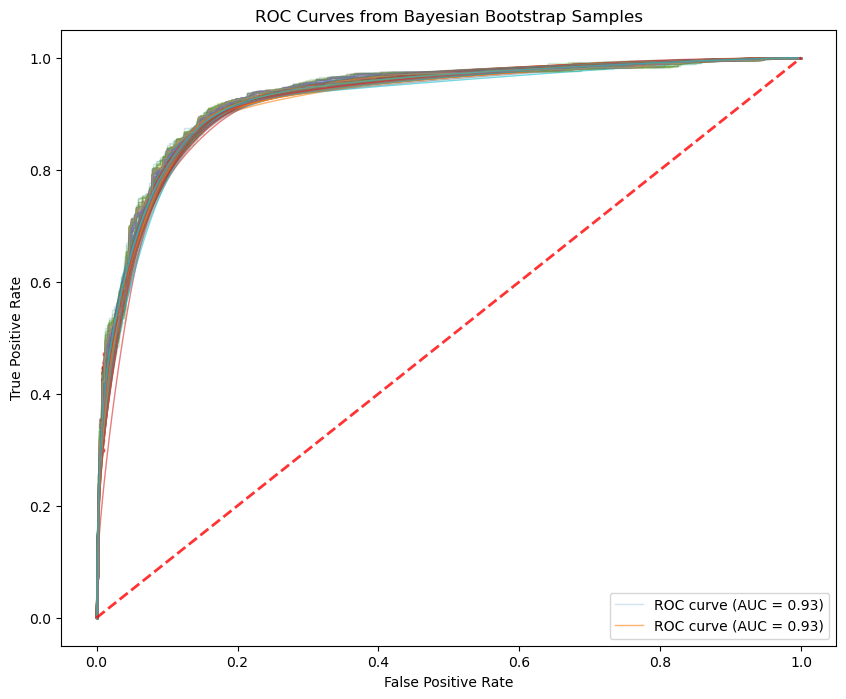

Mean AUC: 0.9324
Standard deviation of AUC: 0.0005


In [107]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

sample_size = 100
slope_of_interest = 10
bootstrapped_X, bootstrapped_y = bayesian_bootstrap(X, y, n_iterations=sample_size)

plt.figure(figsize=(10, 8))

# Initialize a list to store AUC scores
auc_scores = []

# Initialize lists to store results
auc_scores = []
closest_prob_cutoffs = []
original_fprs = []
original_tprs = []
closest_fprs = []
closest_tprs = []
closest_npvs = []
closest_ppvs = []

plt.figure(figsize=(10, 8))

start = time.time()

for i in range(sample_size):
    # Train logistic regression on the i-th bootstrapped sample
    model = LogisticRegression()
    model.fit(bootstrapped_X[i], bootstrapped_y[i])
    
    # Compute the ROC curve and AUC score
    y_pred_proba = model.predict_proba(X)[:, 1]
    fprs, tprs, proba_cutoff = roc_curve(y, y_pred_proba)
    roc_auc = auc(fprs, tprs)
    auc_scores.append(roc_auc)
    
    #bezier
    outer_idx = max_relative_slopes(fprs, tprs)[1]
    
    outer_idx = clean_max_relative_slope_index(outer_idx, len(tprs))
    u_roc_fpr_fitted, u_roc_tpr_fitted = fprs[outer_idx], tprs[outer_idx]
    u_roc_fpr_fitted, u_roc_tpr_fitted = deduplicate_roc_points(u_roc_fpr_fitted, u_roc_tpr_fitted)

    #general rational bezier fit
    control_points = list(zip(u_roc_fpr_fitted, u_roc_tpr_fitted))
    empirical_points = list(zip(fprs, tprs))
    initial_weights = [1] * len(control_points)
    bounds = [(0, 20) for _ in control_points]
    # Optimize weights to fit the empirical points
    result = minimize(error_function, initial_weights, args=(control_points, empirical_points), method='SLSQP', bounds = bounds)
    optimal_weights = result.x

    # Compute the rational Bezier curve with optimal weights
    curve_points = rational_bezier_curve(control_points, optimal_weights)
    cutoff_rational = find_fpr_tpr_for_slope(curve_points, slope_of_interest)

    closest_fpr, closest_tpr = cutoff_rational[0], cutoff_rational[1]
    #find the closest pair of tpr and fpr from the original arrays
    original_tpr, original_fpr, index = find_closest_pair_separate(tprs, fprs, closest_tpr, closest_fpr)
    closest_prob_cutoff = proba_cutoff[index]
    
    # Find the closest probability cutoff (using the point with maximum TPR)
    closest_prob_cutoff = proba_cutoff[index]

    # Compute PPV and NPV for the closest probability cutoff
    y_pred = (y_pred_proba >= closest_prob_cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    closest_ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    closest_npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    closest_prob_cutoffs.append(closest_prob_cutoff)
    original_fprs.append(original_fpr)
    original_tprs.append(original_tpr)
    closest_fprs.append(closest_fpr)
    closest_tprs.append(closest_tpr)
    closest_ppvs.append(closest_ppv)
    closest_npvs.append(closest_npv)
    
    # Plot the ROC curve
    plt.plot(fprs, tprs, lw=1, alpha=0.2, label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")
    plt.plot(curve_points[:, 0], curve_points[:, 1], lw=1, alpha=0.6, label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")
    plt.scatter([original_fpr], [original_tpr], color='red', s=10, alpha=0.6)

end = time.time()
print("Took: ", end-start, " seconds.")

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

plt.title('ROC Curves from Bayesian Bootstrap Samples')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Display summary statistics for AUC scores
print(f"Mean AUC: {np.mean(auc_scores):.4f}")
print(f"Standard deviation of AUC: {np.std(auc_scores):.4f}")

# Output the results
import pandas as pd
results_df = pd.DataFrame({
    'Closest Prob Cutoff': closest_prob_cutoffs,
    'originalFPR': original_fprs,
    'originalTPR': original_tprs,
    'fittedFPR': closest_fprs,
    'fittedTPR': closest_tprs,
    'NPV': closest_npvs,
    'PPV': closest_ppvs
})

# import ace_tools as tools; tools.display_dataframe_to_user(name="Bayesian Bootstrap Results", dataframe=results_df)


In [108]:
json_file_path = 'Results/bayes_100bootstrap_results062624_slope10.json'
results_df.to_json(json_file_path, orient='records', lines=True)

In [109]:
results_df.describe()

,Closest Prob Cutoff,originalFPR,originalTPR,fittedFPR,fittedTPR,NPV,PPV
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.937156,0.009900,0.409104,0.015432,0.406697,0.624630,0.976550
std,0.017070,0.000868,0.032123,0.001715,0.027173,0.012282,0.001061
min,0.892290,0.008032,0.298805,0.011502,0.328345,0.583924,0.973214
25%,0.926676,0.010040,0.402390,0.014269,0.392068,0.621690,0.975845
50%,0.938271,0.010040,0.419323,0.015476,0.409645,0.628426,0.976959
75%,0.949634,0.010040,0.424303,0.016687,0.428087,0.630435,0.977143
max,0.973517,0.012048,0.470120,0.020031,0.460445,0.649077,0.978261


In [99]:
results_df.describe()

,Closest Prob Cutoff,originalFPR,originalTPR,fittedFPR,fittedTPR,NPV,PPV
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.596291,0.096888,0.812610,0.105975,0.809112,0.827095,0.894275
std,0.040089,0.004796,0.009211,0.005513,0.008505,0.006484,0.003851
min,0.502833,0.088353,0.796813,0.092028,0.788919,0.816216,0.882105
25%,0.566009,0.094378,0.804781,0.101983,0.803399,0.821494,0.893246
50%,0.600534,0.094378,0.814741,0.105496,0.809158,0.828413,0.895323
75%,0.625169,0.098394,0.818725,0.109641,0.815202,0.831481,0.896930
max,0.682571,0.112450,0.836653,0.119365,0.828428,0.844106,0.902222


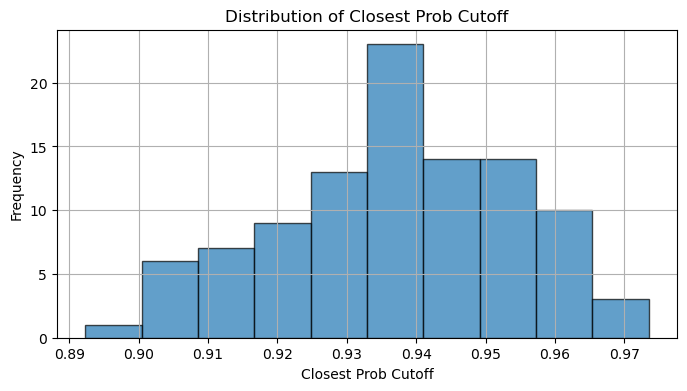

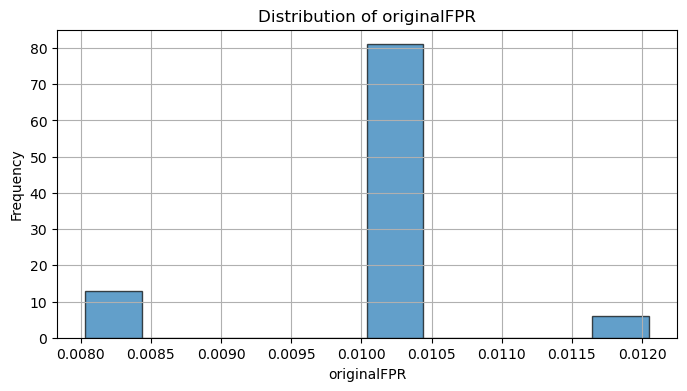

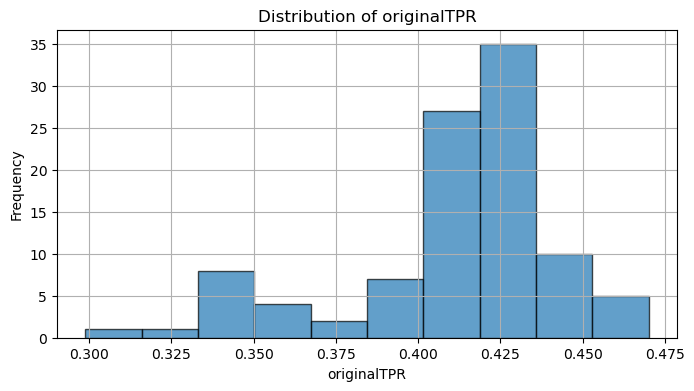

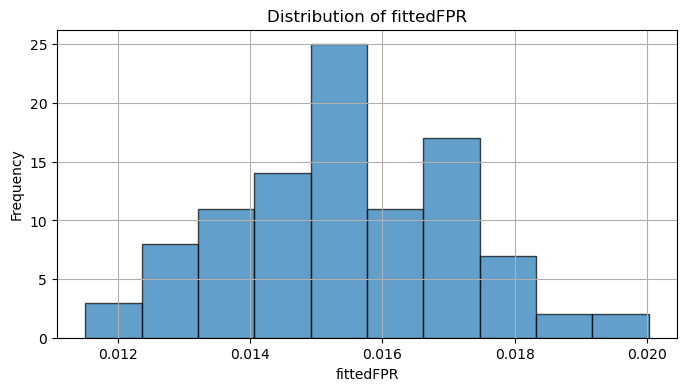

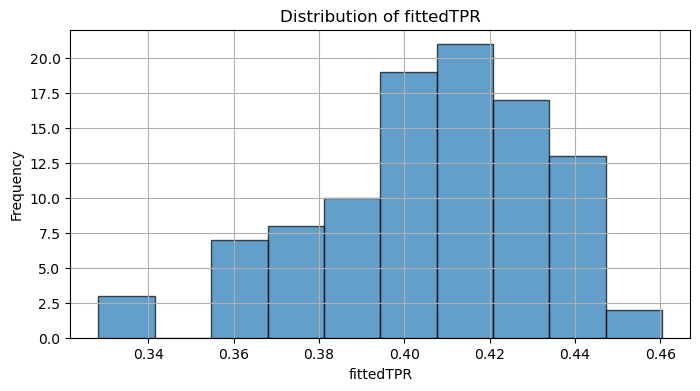

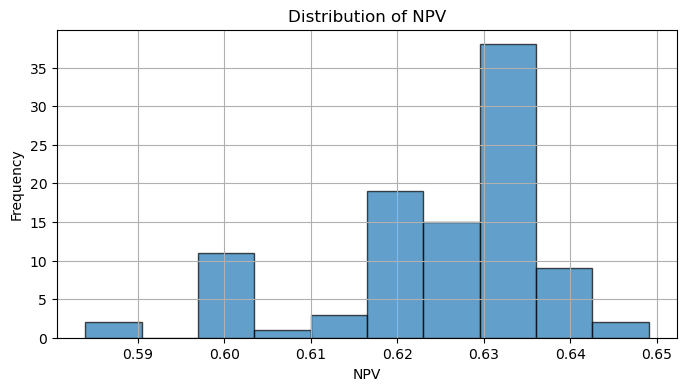

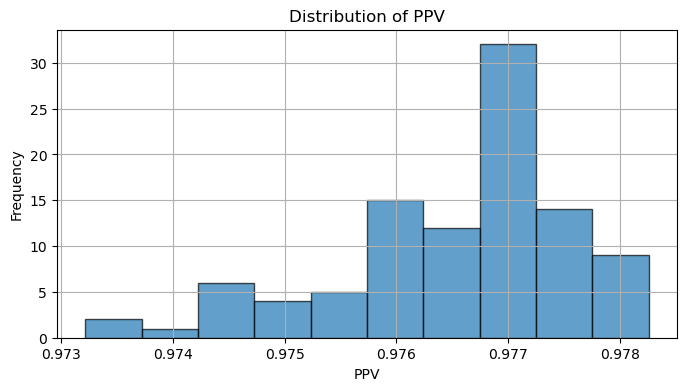

In [110]:
columns = results_df.columns
for column in columns:
    plt.figure(figsize=(8, 4))
    plt.hist(results_df[column], bins=10, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:533: RuntimeWarning: invalid value encountered in divide
  curve_point = numerator / denominator
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / 

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:533: RuntimeWarning: invalid value encountered in divide
  curve_point = numerator / denominator
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / 

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:533: RuntimeWarning: invalid value encountered in divide
  curve_point = numerator / denominator
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / 

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (t

Took:  8600.9282579422  seconds.


<Figure size 1000x800 with 0 Axes>

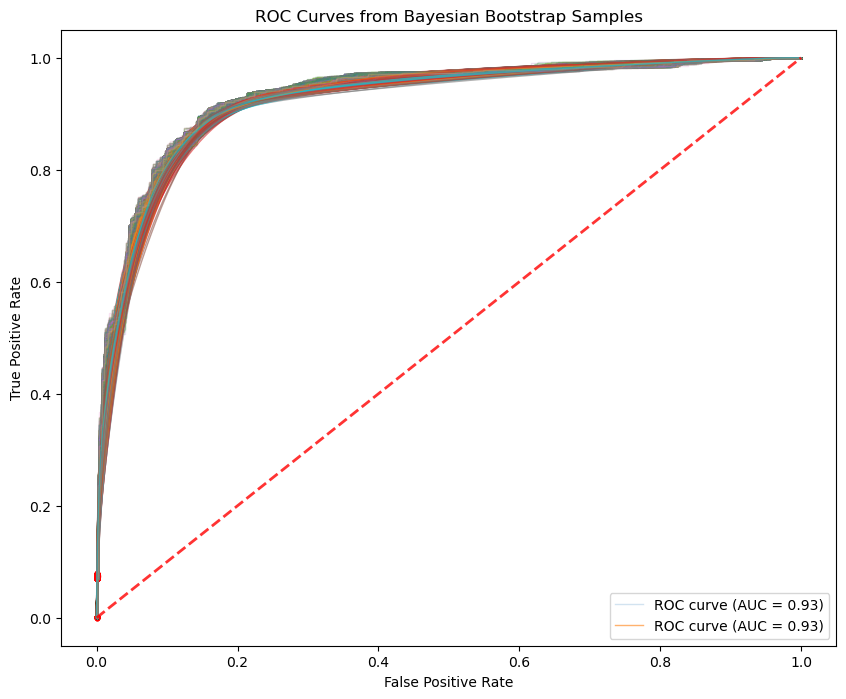

Mean AUC: 0.9324
Standard deviation of AUC: 0.0005


In [126]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

sample_size = 1000
slope_of_interest = 100
bootstrapped_X, bootstrapped_y = bayesian_bootstrap(X, y, n_iterations=sample_size)

plt.figure(figsize=(10, 8))

# Initialize a list to store AUC scores
auc_scores = []

# Initialize lists to store results
auc_scores = []
closest_prob_cutoffs = []
original_fprs = []
original_tprs = []
closest_fprs = []
closest_tprs = []
closest_npvs = []
closest_ppvs = []

plt.figure(figsize=(10, 8))

start = time.time()

for i in range(sample_size):
    # Train logistic regression on the i-th bootstrapped sample
    model = LogisticRegression()
    model.fit(bootstrapped_X[i], bootstrapped_y[i])
    
    # Compute the ROC curve and AUC score
    y_pred_proba = model.predict_proba(X)[:, 1]
    fprs, tprs, proba_cutoff = roc_curve(y, y_pred_proba)
    roc_auc = auc(fprs, tprs)
    auc_scores.append(roc_auc)
    
    #bezier
    outer_idx = max_relative_slopes(fprs, tprs)[1]
    
    outer_idx = clean_max_relative_slope_index(outer_idx, len(tprs))
    u_roc_fpr_fitted, u_roc_tpr_fitted = fprs[outer_idx], tprs[outer_idx]
    u_roc_fpr_fitted, u_roc_tpr_fitted = deduplicate_roc_points(u_roc_fpr_fitted, u_roc_tpr_fitted)

    #general rational bezier fit
    control_points = list(zip(u_roc_fpr_fitted, u_roc_tpr_fitted))
    empirical_points = list(zip(fprs, tprs))
    initial_weights = [1] * len(control_points)
    bounds = [(0, 20) for _ in control_points]
    # Optimize weights to fit the empirical points
    result = minimize(error_function, initial_weights, args=(control_points, empirical_points), method='SLSQP', bounds = bounds)
    optimal_weights = result.x

    # Compute the rational Bezier curve with optimal weights
    curve_points = rational_bezier_curve(control_points, optimal_weights)
    cutoff_rational = find_fpr_tpr_for_slope(curve_points, slope_of_interest)

    closest_fpr, closest_tpr = cutoff_rational[0], cutoff_rational[1]
    #find the closest pair of tpr and fpr from the original arrays
    original_tpr, original_fpr, index = find_closest_pair_separate(tprs, fprs, closest_tpr, closest_fpr)
    closest_prob_cutoff = proba_cutoff[index]
    
    # Find the closest probability cutoff (using the point with maximum TPR)
    closest_prob_cutoff = proba_cutoff[index]

    # Compute PPV and NPV for the closest probability cutoff
    y_pred = (y_pred_proba >= closest_prob_cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    closest_ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    closest_npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    closest_prob_cutoffs.append(closest_prob_cutoff)
    original_fprs.append(original_fpr)
    original_tprs.append(original_tpr)
    closest_fprs.append(closest_fpr)
    closest_tprs.append(closest_tpr)
    closest_ppvs.append(closest_ppv)
    closest_npvs.append(closest_npv)
    
    # Plot the ROC curve
    plt.plot(fprs, tprs, lw=1, alpha=0.2, label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")
    plt.plot(curve_points[:, 0], curve_points[:, 1], lw=1, alpha=0.6, label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")
    plt.scatter([original_fpr], [original_tpr], color='red', s=10, alpha=0.6)

end = time.time()
print("Took: ", end-start, " seconds.")

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

plt.title('ROC Curves from Bayesian Bootstrap Samples')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Display summary statistics for AUC scores
print(f"Mean AUC: {np.mean(auc_scores):.4f}")
print(f"Standard deviation of AUC: {np.std(auc_scores):.4f}")

# Output the results
import pandas as pd
results_df = pd.DataFrame({
    'Closest Prob Cutoff': closest_prob_cutoffs,
    'originalFPR': original_fprs,
    'originalTPR': original_tprs,
    'fittedFPR': closest_fprs,
    'fittedTPR': closest_tprs,
    'NPV': closest_npvs,
    'PPV': closest_ppvs
})

# import ace_tools as tools; tools.display_dataframe_to_user(name="Bayesian Bootstrap Results", dataframe=results_df)


In [130]:
json_file_path = 'Results/bayes_1000bootstrap_results062624_slope100.json'
results_df.to_json(json_file_path, orient='records')
results_df.describe()

,Closest Prob Cutoff,originalFPR,originalTPR,fittedFPR,fittedTPR,NPV,PPV
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,inf,0.000002,0.057034,3.329515e-04,5.051121e-02,0.512793,0.994974
std,NaN,0.000063,0.029241,1.290702e-04,1.888662e-02,0.007595,0.070572
min,0.990309,0.000000,0.000000,1.464243e-08,7.517653e-07,0.498000,0.000000
25%,0.996576,0.000000,0.069721,2.572534e-04,3.940122e-02,0.516062,1.000000
50%,0.997800,0.000000,0.071713,3.484777e-04,5.221864e-02,0.516598,1.000000
75%,0.999063,0.000000,0.073705,4.082480e-04,6.205201e-02,0.517134,1.000000
max,inf,0.002008,0.079681,1.070795e-03,1.385551e-01,0.518750,1.000000


In [121]:
# Reading the JSON file into a DataFrame
json_file_path = 'Results/bayes_1000bootstrap_results062624_slope10.json'

results_df = pd.read_json(json_file_path)
results_df.describe()

,Closest Prob Cutoff,originalFPR,originalTPR,fittedFPR,fittedTPR,NPV,PPV
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.936181,0.010066,0.412271,0.015563,0.407944,0.625843,0.976379
std,0.018821,0.001250,0.031320,0.002660,0.027818,0.012026,0.001705
min,0.861835,0.006024,0.274900,0.009335,0.270844,0.576251,0.945525
25%,0.925075,0.010040,0.402390,0.014007,0.392253,0.621690,0.975845
50%,0.937836,0.010040,0.422311,0.015062,0.410839,0.629630,0.976879
75%,0.949068,0.010040,0.424303,0.016628,0.425915,0.630435,0.977064
max,0.980807,0.028112,0.515936,0.031014,0.508765,0.668486,0.979487


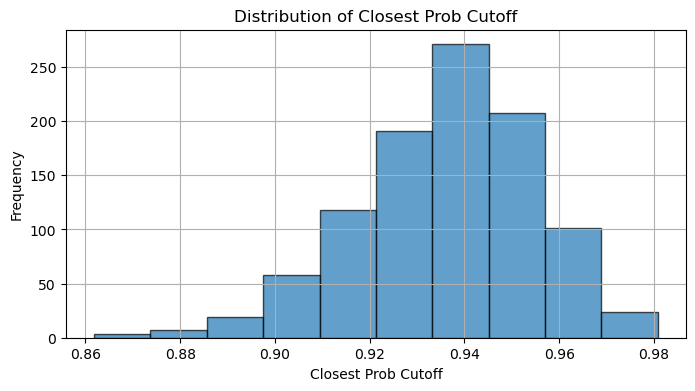

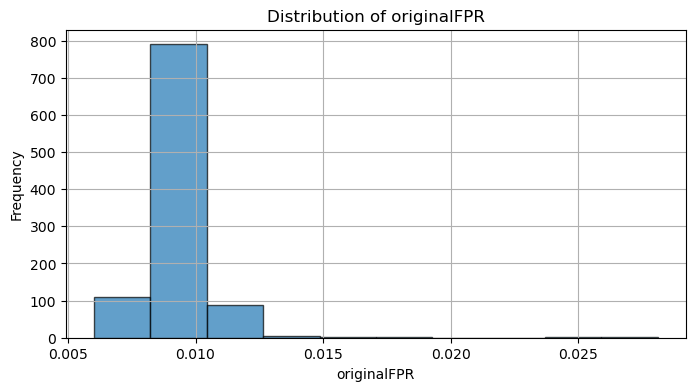

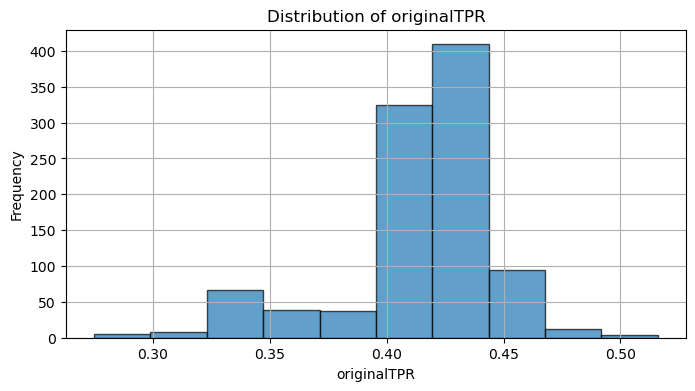

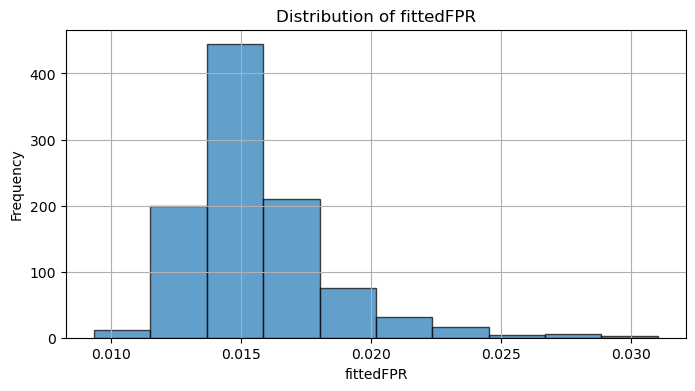

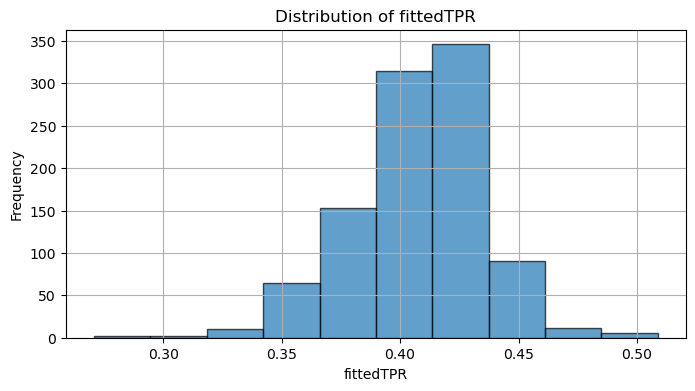

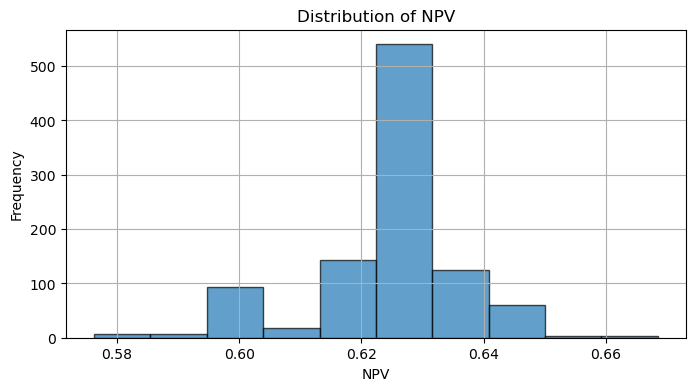

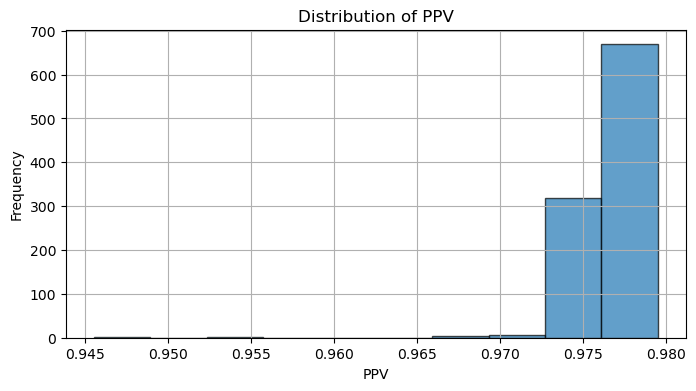

In [122]:
columns = results_df.columns
for column in columns:
    plt.figure(figsize=(8, 4))
    plt.hist(results_df[column], bins=10, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

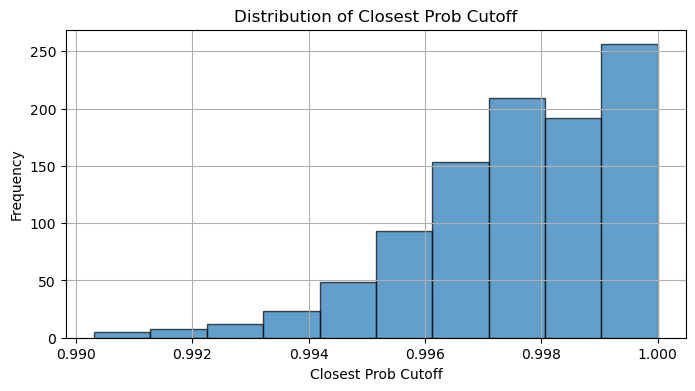

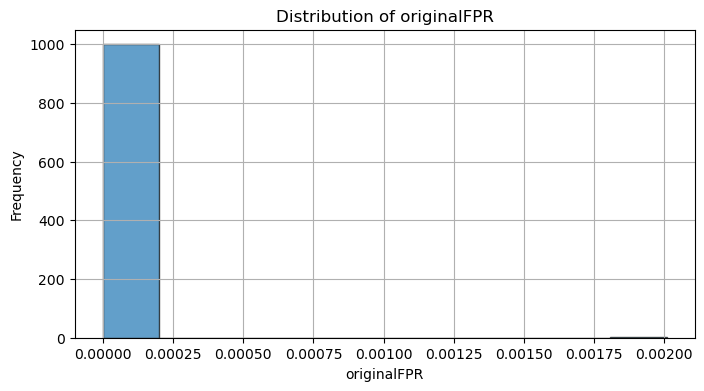

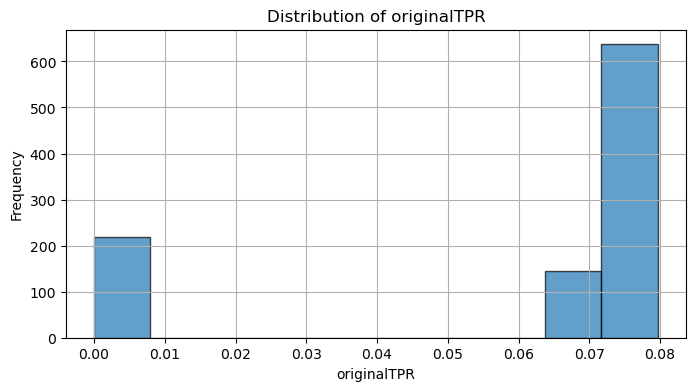

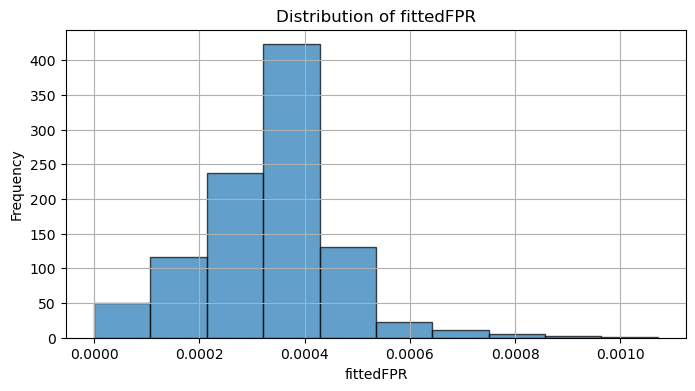

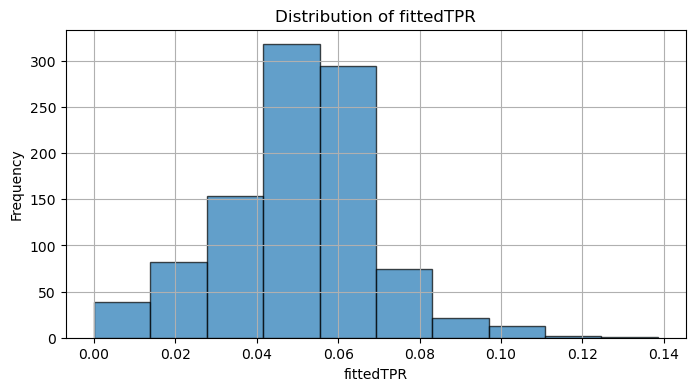

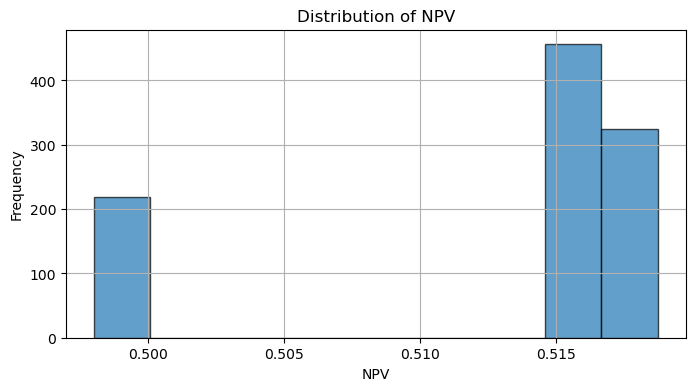

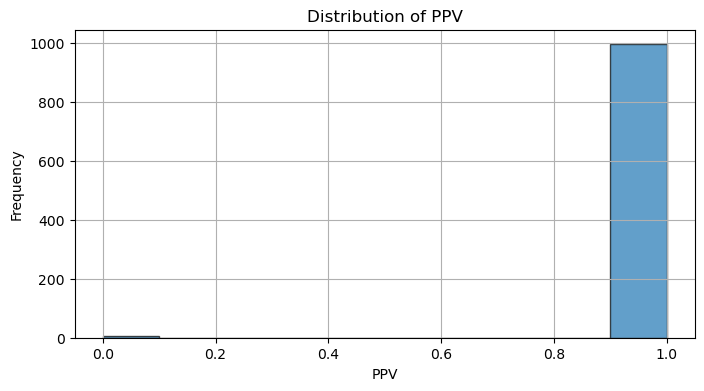

In [133]:
columns = results_df.columns
results_df['Closest Prob Cutoff'] = results_df['Closest Prob Cutoff'].replace([np.inf, -np.inf], 1)

for column in columns:
    plt.figure(figsize=(8, 4))
    plt.hist(results_df[column], bins=10, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Results

In [78]:
#get distribution of probability cutoff, fpr, tpr, ppv, npv (95% credible interval)
def compute_percentiles(df):
    percentiles = df.apply(lambda x: pd.Series({
        '2.5th Percentile': np.percentile(x, 2.5),
        '97.5th Percentile': np.percentile(x, 97.5)
    }))
    return percentiles

# Compute the percentiles
percentiles = compute_percentiles(results_df)
print(percentiles)
#get mean expected utility


                   Closest Prob Cutoff       FPR       TPR       NPV       PPV
2.5th Percentile              0.511498  0.090361  0.794821  0.814748  0.884615
97.5th Percentile             0.690390  0.108434  0.830677  0.840525  0.900442


In [131]:
# Compute the percentiles
percentiles = compute_percentiles(results_df)
print(percentiles)
#get mean expected utility

                   Closest Prob Cutoff  originalFPR  originalTPR  fittedFPR  \
2.5th Percentile              0.993283          0.0     0.001992   0.000063   
97.5th Percentile             0.999971          0.0     0.077689   0.000591   

                   fittedTPR       NPV  PPV  
2.5th Percentile    0.009810  0.498498  1.0  
97.5th Percentile   0.088223  0.518210  1.0  


In [132]:
results_df.mean()

Closest Prob Cutoff         inf
originalFPR            0.000002
originalTPR            0.057034
fittedFPR              0.000333
fittedTPR              0.050511
NPV                    0.512793
PPV                    0.994974
dtype: float64

# Repeat for another model and compare results (distribution of optimal point, utility, for a given preference tradeoff)

In [87]:
#get difference in mean expected utility
results_df.mean()[0]

0.5982444717406674

In [88]:
prob, sens, spec = results_df.mean()[0], results_df.mean()[1], results_df.mean()[2]
uTN = 1
uFN = 0
uTP = 0.8
uFP = 0.85
u = 0

In [92]:
test(prob, sens, spec, uTN, uTP, uFN, uFP, u) - test(prob, sens *0.9, spec*1.1, uTN, uTP, uFN, uFP, u)

-0.0002254519027952151

In [165]:
from statsmodels.stats.power import TTestIndPower

effect_size =  1.5 # mean difference divided by standard deviation
alpha = 0.05
power = 0.8

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, alpha=alpha, ratio=1)
print(sample_size)

2.1172200594580453
